# [IT8302] Applied Machine Learning: Housing Sales

## Table of Contents
1. [Libraries](#1)
2. [Exploratory Data Analysis](#2)
3. [Feature Engineering](#3)
4. [Modelling](#4)
5. [Conclusion](#5)

__Introduction__  
This project focuses on predicting housing prices in King County, USA, using machine learning regression models and housing data from May 2014 to May 2015.

__Datasets used__  
- [USA King Country Housing Kaggle Dataset](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)
- [Zipcodes for King County and Surrounding Area (Shorelines)](https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-shorelines-zipcode-shore-area/about)

# 1. Import Libraries <a id = '1'></a>

In [1]:
import warnings
from time import sleep

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from scipy.stats import skew
from shapely.geometry import Point
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

# 2. Exploratory Data Analysis (EDA) <a id = '2'></a> 

__Metadata__  
The following table summarises information on each variable within the King County housing dataset. There are a total of 21 variables, with price being the response variable.

| S/N | Variable | Data Type | Description |
| :-- | :-- | :-- | :-- |
| 1 | `id` | Integer | Unique ID of each house sold |
| 2 | `date` | Datetime | Date of each house sold |
| 3 | `price` | Float | Price of each house sold |
| 4 | `bedrooms` | Integer | Number of bedrooms |
| 5 | `bathrooms` | Float | Number of bathrooms (decimals indicate number of fixtures out of a sink, toilet, shower, or a bath) |
| 6 | `sqft_living` | Integer | Livable area in square foot |
| 7 | `sqft_lot` | Integer | Total land area in square foot (includes yard, garden, if any) |
| 8 | `floors` | Float | Number of floors |
| 9 | `waterfront` | Categorical | Binary variable whether home has a waterfront view |
| 10 | `view` | Categorical | Rating of 0-4 on how good the view from the house |
| 11 | `condition` | Categorical | Rating of 1-5 on the condition of the house |
| 12 | `grade` | Categorical | Rating of 1-13 of the house's building construction grade |
| 13 | `sqft_above` | Integer | Above-ground level area in square foot |
| 14 | `sqft_basement` | Integer | Below-ground level area in square foot |
| 15 | `yr_built` | Integer | Year of construction |
| 16 | `yr_renovated` | Integer | Year of last renovation |
| 17 | `zipcode` | Categorical | Zipcode area of house |
| 18 | `lat` | Float | Latitude |
| 19 | `long` | Float | Longitude |
| 20 | `sqft_living15` | Integer | Average living area of the nearest 15 neighbours in square feet |
| 21 | `sqft_lot15` | Integer | Average land area of the nearest 15 neighbours in square feet |

First, we begin by loading and inspecting the dataset to understand its structure. The dataset is checked for null values, and a summary table of all variables is created to understand their data types and value ranges.

In [2]:
# Read train and test data
housing_df = pd.read_csv(
    "data/kc_house_data.csv", parse_dates=["date"], infer_datetime_format=True
)

# Inspect dataframe
print(housing_df.info())  # no null values
housing_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Next, descriptive statistics are calculated for all variables to explore their distributions. Notably, a right-skew in housing prices is observed (mean > median) suggesting the presence of outliers. Additionally, key variables like `waterfront` are boolean, while `view`, `condition`, and `grade` appear to be ordinal in nature.

In [3]:
# Get descriptive stats
housing_df.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,2014-10-29 04:38:01.959931648,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
min,1.000102e+06,2014-05-02 00:00:00,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,2014-07-22 00:00:00,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,2015-02-17 00:00:00,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,2015-05-27 00:00:00,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000
std,2.876566e+09,NaN,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631


Plotting a histogram of price, the skew is confirmed with a right-skew of 4.02, indicating outliers in housing prices.

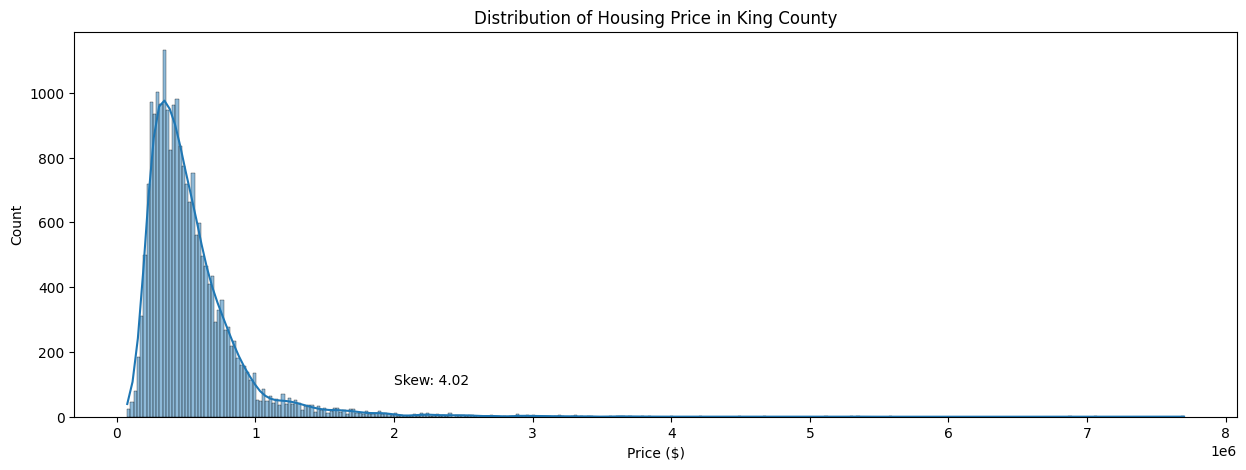

In [4]:
# Plot histogram to visualise distribution of housing price
plt.figure(figsize=(15, 5))
sns.histplot(data=housing_df, x="price", kde=True)
plt.title("Distribution of Housing Price in King County")
plt.xlabel(f"Price ($)")
plt.text(2e6, 100, f"Skew: {skew(housing_df['price']):.2f}")
plt.show()

To identify potential predictors, a pairplot is used to visualise relationships between price and relevant numerical variables. Zipcode, latitude, and longitude are excluded from this plot as they may not show any meaningful correlations with price. However, we will come back to use `lat` and `long` to analyse distributions in housing prices as spatial autocorrelations are likely exist.

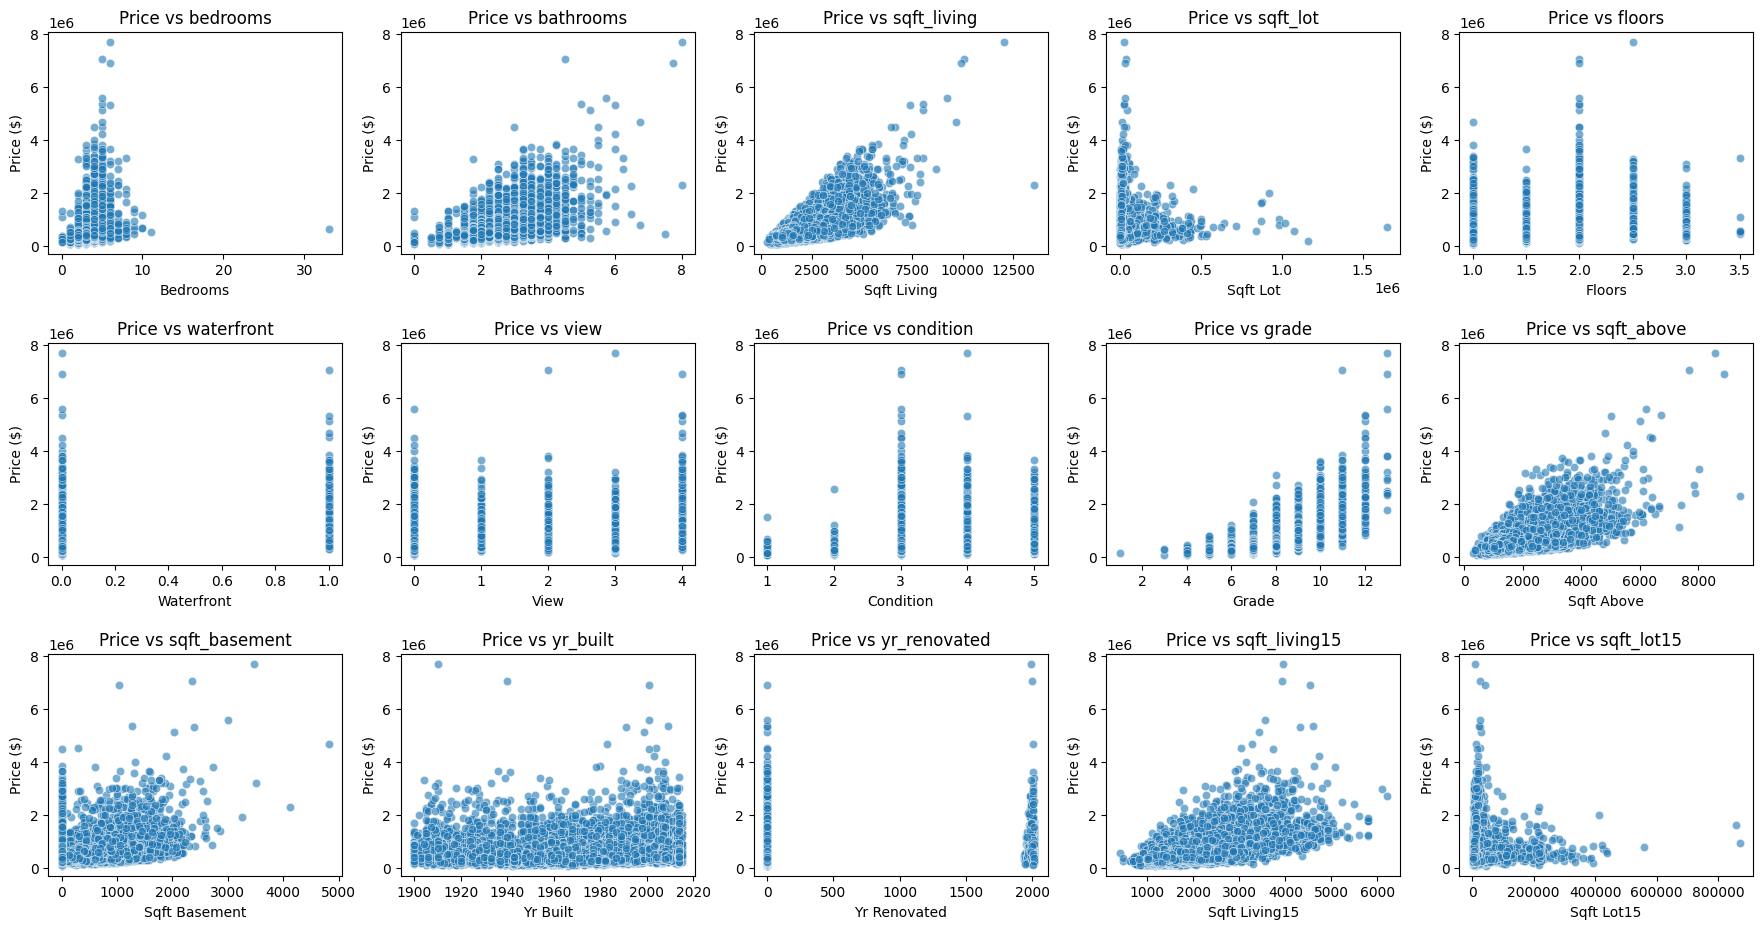

In [5]:
# Pairplot for quick overview on relationships between price and relevant numerical variables
pairplot_cols = [
    "bedrooms",  # normal distribution?
    "bathrooms",  # potential missing values (bathrooms = 0)
    "sqft_living",  # strong positive correlation with price
    "sqft_lot",  # lots of houses with small lots close to 0 sqft
    "floors",  # moderate negative correlation with price (potentially non-linear, houses can be landed or apartment)
    "waterfront",  # no observable correlation
    "view",  # weak to no correlation with price
    "condition",  # moderate positive correlation with price
    "grade",  # strong positive correlation with price
    "sqft_above",  # strong positive correlation with price
    "sqft_basement",  # some missing values, maybe because house has no basement
    "yr_built",  # missing values (year = 0)
    "yr_renovated",  # doesn't seem to be meaningful to predict price
    # "zipcode", # remove as it is categorical with no meaningful arithmetic
    # "lat", # remove as not meaningful to correlate with other variables
    # "long", # remove as not meaningful to correlate with other variables
    "sqft_living15",  # almost the same as sqft_living
    "sqft_lot15",  # almost the same as sqft_lot
]

# Create scatter plots for each feature
num_cols = 5
num_rows = len(pairplot_cols) // num_cols + 1

plt.figure(figsize=(22, 15))
for i, col in enumerate(pairplot_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.scatterplot(data=housing_df, y="price", x=col, alpha=0.6)
    plt.title(f"Price vs {col}")
    plt.xlabel(f"{col.title().replace('_', ' ')}")
    plt.ylabel("Price ($)")

# Adjust layout
plt.subplots_adjust(hspace=0.4)
plt.show()

From the above pairplot, it appears that `bathrooms`, `sqft_living`, `grade`, `sqft_above`, `sqft_basement`, `sqft_living15`, and `sqft_lot15` are positively correlated with price. To confirm this, a correlation heatmap was plotted to elucidate more clearly the relationships between the variables.

<Figure size 800x500 with 0 Axes>

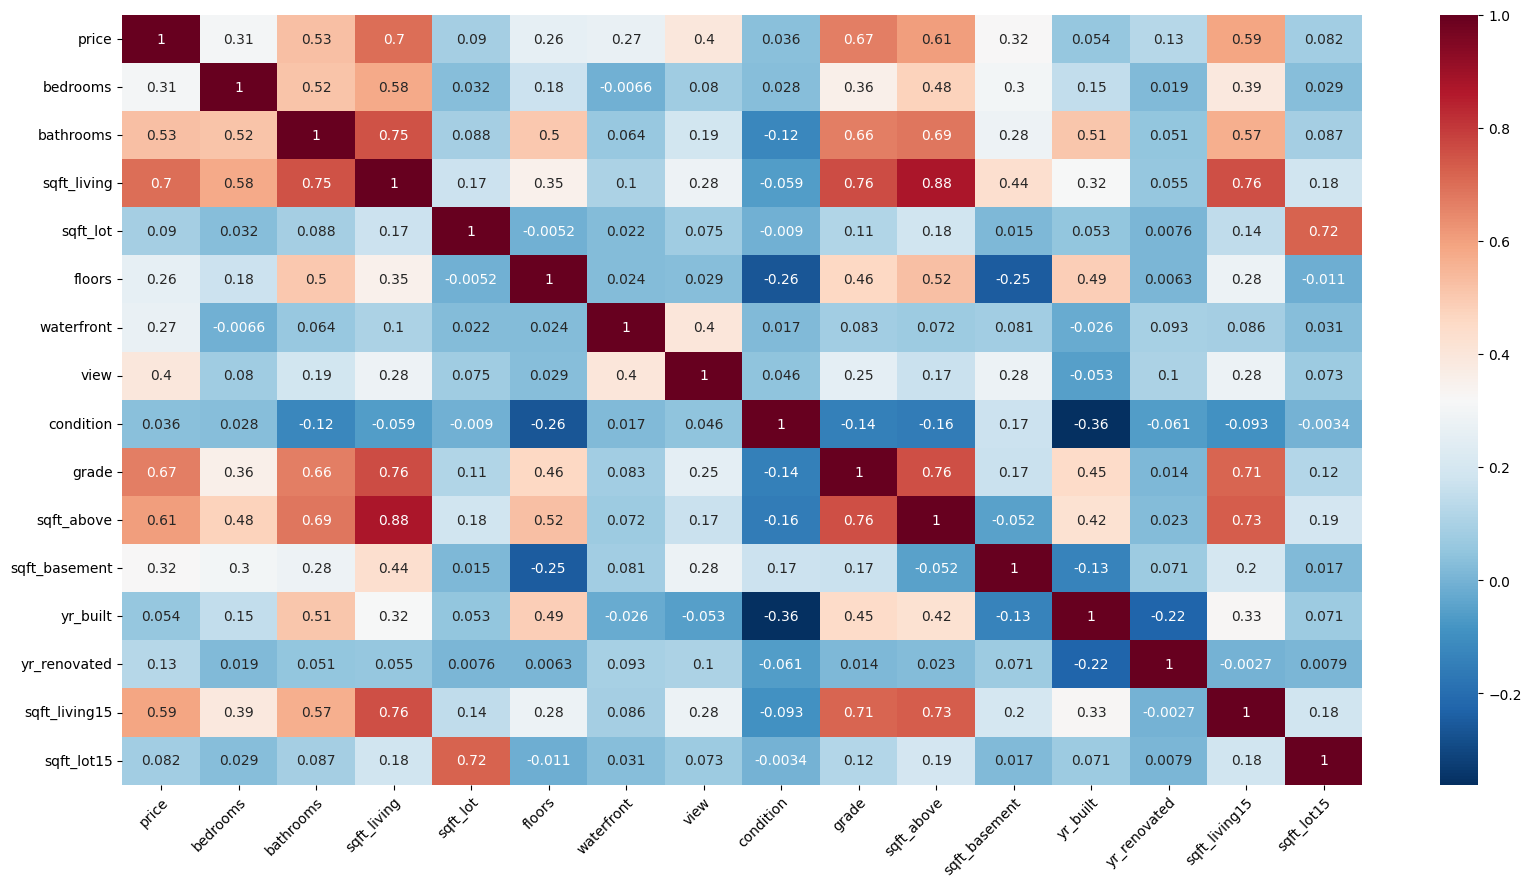

In [6]:
# Heatmap to plot out correlation between price and other relevant independent variables
plt.figure(figsize=(8, 5))

heatmap_cols = [
    "price",
    "bedrooms",  # weak positive correlation
    "bathrooms",  # moderate positive correlation
    "sqft_living",  # strong positive correlation
    "sqft_lot",  # no correlation
    "floors",  # weak positive correlation
    "waterfront",  # weak correlation
    "view",  # weak positive correlation
    "condition",  # no correlation
    "grade",  # moderate positive correlation
    "sqft_above",  # moderate positive correlation
    "sqft_basement",  # weak positive correlation
    "yr_built",  # weak positive correlation
    "yr_renovated",  # weak positive correlation
    "sqft_living15",  # moderate strong correlation
    "sqft_lot15",  # weak positive correlation
]

corr = housing_df[heatmap_cols].corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap="RdBu_r")
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

Based on the pairplot and correlation heatmap, variables that have a moderate to strong correlation with price are:
- `bathrooms` (0.53)
- `sqft_living` (0.7)
- `view` (0.4)
- `grade` (0.67)
- `sqft_above` (0.61)
- `sqft_living15` (0.59)

To ensure robustness in our linear regression models, we detected for multi-collinearity between predictor variables as well.

In [7]:
# Finding pairs with high correlation of more than 0.7
highly_correlated_pairs = []

for i in range(len(corr.columns)):
    for j in range(i):
        correlation_value = abs(corr.iloc[i, j])

        if correlation_value > 0.7:
            col_pair = (corr.columns[i], corr.columns[j], correlation_value)
            highly_correlated_pairs.append(col_pair)

for pair in highly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]:.2f}")

sqft_living and price: Correlation = 0.70
sqft_living and bathrooms: Correlation = 0.75
grade and sqft_living: Correlation = 0.76
sqft_above and sqft_living: Correlation = 0.88
sqft_above and grade: Correlation = 0.76
sqft_living15 and sqft_living: Correlation = 0.76
sqft_living15 and grade: Correlation = 0.71
sqft_living15 and sqft_above: Correlation = 0.73
sqft_lot15 and sqft_lot: Correlation = 0.72


To mitigate the effects of multi-collinearity, which can result in unstable and unreliable coefficient estimates and confound the interpretability of results and the ability to draw meaningful conclusions, Variance Inflation Factor (VIF) was calculated to address multi-collinearity by removing variables with VIF ≥ 5.

In [8]:
# Define function to calculate VIF
def calculate_vif(df, cols_to_drop):
    sleep(0.5)
    # Define the predictor variables
    predictors_df = df.copy()

    # Drop columns, if any
    if cols_to_drop:
        predictors_df = df.drop(columns=cols_to_drop)

    # Add a constant (intercept)
    X = add_constant(predictors_df)

    # Calculate VIF for each feature
    vif_df = pd.DataFrame(
        {
            "Features": X.columns,
            "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
        }
    )

    # Flag out if VIF ≥ 5
    if sum(vif_df[vif_df["Features"] != "const"]["VIF"] >= 5) > 0:
        logger.warning("Multi-collinearity detected!")
    else:
        logger.success("No multi-collinearity, VIF all under 5")

    sleep(0.5)
    return vif_df

After removing `sqft_living`, all predictors show VIF values below 5, ensuring the robustness of the regression model.

In [9]:
# Define df for calculating vif
vif_df = housing_df[heatmap_cols].drop(columns="price")

# Calculate VIF of all variables
logger.debug("Calculating VIF for all variables...")
print(calculate_vif(vif_df, cols_to_drop=None), "\n")

# Drop sqft_living and calculate VIF
sleep(0.5)
logger.debug("Dropping sqft_living and calculating VIF...")
print(calculate_vif(vif_df, cols_to_drop=["sqft_living"]), "\n")

2024-12-01 16:28:15.823 | DEBUG    | __main__:<module>:5 - Calculating VIF for all variables...
2024-12-01 16:28:16.572 | WARNING  | __main__:calculate_vif:24 - Multi-collinearity detected!


         Features          VIF
0           const  8868.539614
1        bedrooms     1.644100
2       bathrooms     3.347865
3     sqft_living          inf
4        sqft_lot     2.088121
5          floors     1.931951
6      waterfront     1.203090
7            view     1.404261
8       condition     1.221646
9           grade     3.234590
10     sqft_above          inf
11  sqft_basement          inf
12       yr_built     2.012114
13   yr_renovated     1.143750
14  sqft_living15     2.817999
15     sqft_lot15     2.118475 



2024-12-01 16:28:17.585 | DEBUG    | __main__:<module>:10 - Dropping sqft_living and calculating VIF...
2024-12-01 16:28:18.373 | SUCCESS  | __main__:calculate_vif:26 - No multi-collinearity, VIF all under 5


         Features          VIF
0           const  8868.539614
1        bedrooms     1.644100
2       bathrooms     3.347865
3        sqft_lot     2.088121
4          floors     1.931951
5      waterfront     1.203090
6            view     1.404261
7       condition     1.221646
8           grade     3.234590
9      sqft_above     4.829579
10  sqft_basement     1.974686
11       yr_built     2.012114
12   yr_renovated     1.143750
13  sqft_living15     2.817999
14     sqft_lot15     2.118475 



We further explored the distributions of housing price across the different levels of categorical variables such as `floors`, `view`, `condition`, `waterfront view`, and `grade` using boxplots. General observations include:
- Median housing price increases with floors up to 2.5 but decreases for higher floors and 
- Housing price increases with better views, waterfront properties, and higher construction grades.

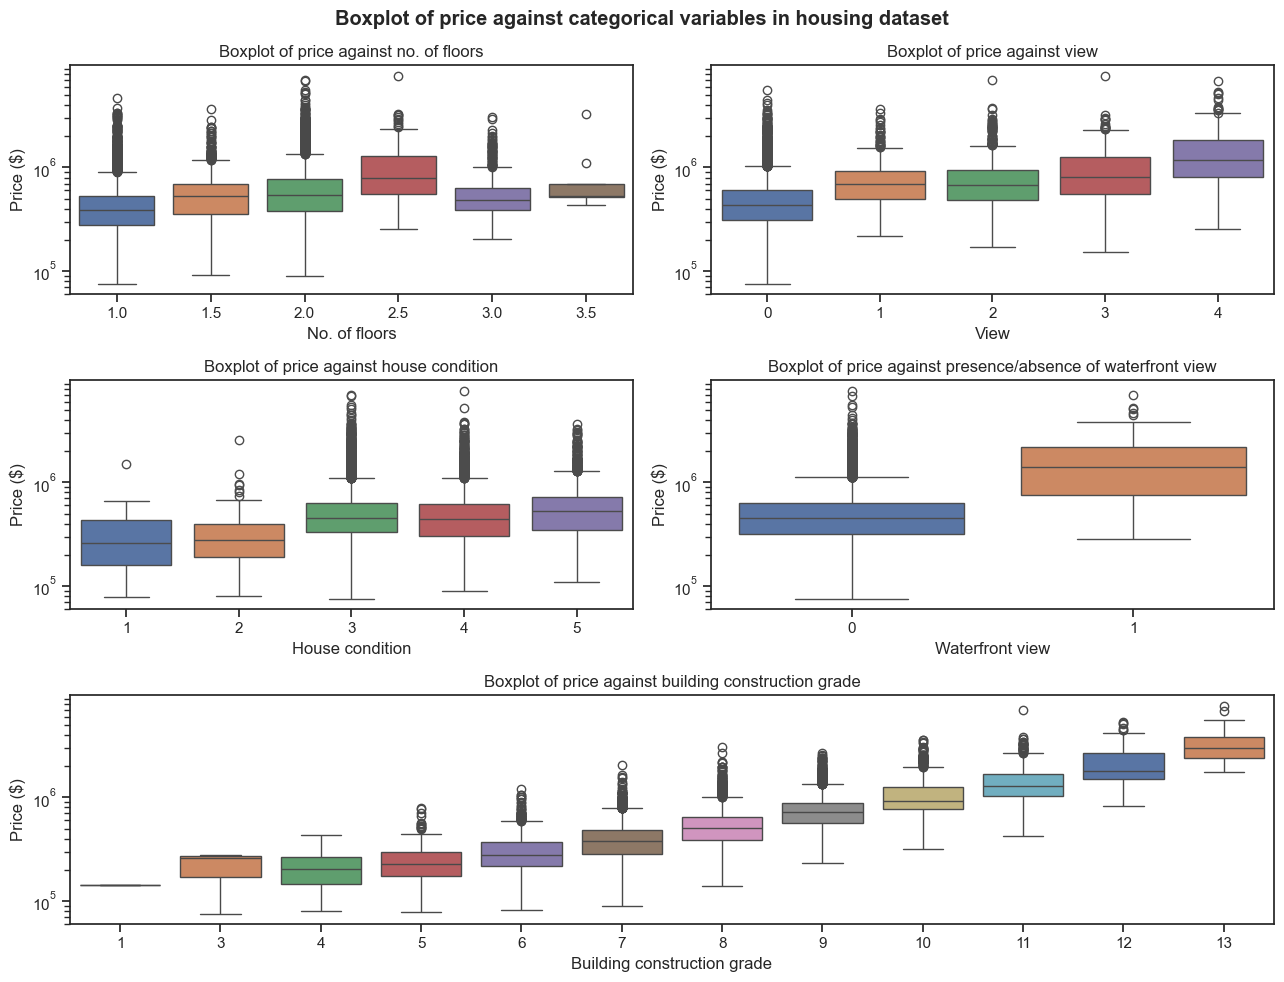

In [11]:
# Set theme and style
sns.set(style="ticks", palette=sns.color_palette("deep"))

# Set figure size for multiple plots
plt.figure(figsize=(13, 10))
plt.suptitle(
    "Boxplot of price against categorical variables in housing dataset",
    fontweight="bold",
)
plt.subplots_adjust(top=0.93)

# Floor
plt.subplot(3, 2, 1)
sns.boxplot(
    data=housing_df,
    x="floors",
    y="price",
    palette=sns.color_palette("deep", n_colors=housing_df["floors"].nunique()),
)
# plt.gca().set_yticklabels([f"${int(i)}M" for i in np.arange(-1, 9)])
plt.yscale("log")
plt.xlabel("No. of floors")
plt.ylabel("Price ($)")
plt.title("Boxplot of price against no. of floors")

# View
plt.subplot(3, 2, 2)
sns.boxplot(
    data=housing_df,
    x="view",
    y="price",
    palette=sns.color_palette("deep", n_colors=housing_df["view"].nunique()),
)
# plt.gca().set_yticklabels([f"${int(i)}M" for i in np.arange(-1, 9)])
plt.yscale("log")
plt.xlabel("View")
plt.ylabel("Price ($)")
plt.title("Boxplot of price against view")

# Condition
plt.subplot(3, 2, 3)
sns.boxplot(
    data=housing_df,
    x="condition",
    y="price",
    palette=sns.color_palette("deep", n_colors=housing_df["condition"].nunique()),
)
# plt.gca().set_yticklabels([f"${int(i)}M" for i in np.arange(-1, 9)])
plt.yscale("log")
plt.xlabel("House condition")
plt.ylabel("Price ($)")
plt.title("Boxplot of price against house condition")

# ConditionWaterfront
plt.subplot(3, 2, 4)
sns.boxplot(
    data=housing_df,
    x="waterfront",
    y="price",
    palette=sns.color_palette("deep", n_colors=housing_df["waterfront"].nunique()),
)
# plt.gca().set_yticklabels([f"${int(i)}M" for i in np.arange(-1, 9)])
plt.yscale("log")
plt.xlabel("Waterfront view")
plt.ylabel("Price ($)")
plt.title("Boxplot of price against presence/absence of waterfront view")

# Grade
plt.subplot(3, 1, 3)
sns.boxplot(
    data=housing_df,
    x="grade",
    y="price",
    palette=sns.color_palette("deep", n_colors=housing_df["grade"].nunique()),
)
# plt.gca().set_yticklabels([f"${int(i)}M" for i in np.arange(-1, 9)])
plt.yscale("log")
plt.xlabel("Building construction grade")
plt.ylabel("Price ($)")
plt.title("Boxplot of price against building construction grade")

plt.tight_layout()
plt.show()

# 3. Feature Engineering <a id = '3'></a> 

In this step, we create new features for the entire dataset to enhance its predictive power. These transformations are applied uniformly to both the training and test datasets to ensure consistency before performing the `train_test_split`. The newly added features are as follows:

Features added include:
1. __Renovation Indicator__: A binary variable indicating whether the house has undergone renovation before (based on whether there is a valid renovation year)
2. __Basement Indicator__: A binary variable indicating whether the house has a basement (based on whether `sqft_basement` > 0)
3. __Relative House Size__: The size of the house relative to the average of its 15 nearest neighbours. This serves to benchmark the price of the house vis-a-vis the market based on size.
4. __House Age__: Age of the house as of date of sale.

In [12]:
# Renovation indicator
housing_df["renovation"] = np.where(housing_df["yr_renovated"] == 0, 0, 1)

# Basement indicator
housing_df["basement"] = np.where(housing_df["sqft_basement"] == 0, 0, 1)

# % of sqft_living relative to nearest 15 neighbours
housing_df["market_living_area_pct"] = (
    housing_df["sqft_living"] / housing_df["sqft_living15"]
)

# Age of house (as of date of sale)
housing_df["house_age"] = housing_df["date"].dt.year - housing_df["yr_built"]

Correlation and VIF were recalculated to confirm no additional multi-collinearity after feature engineering.

<Figure size 800x500 with 0 Axes>

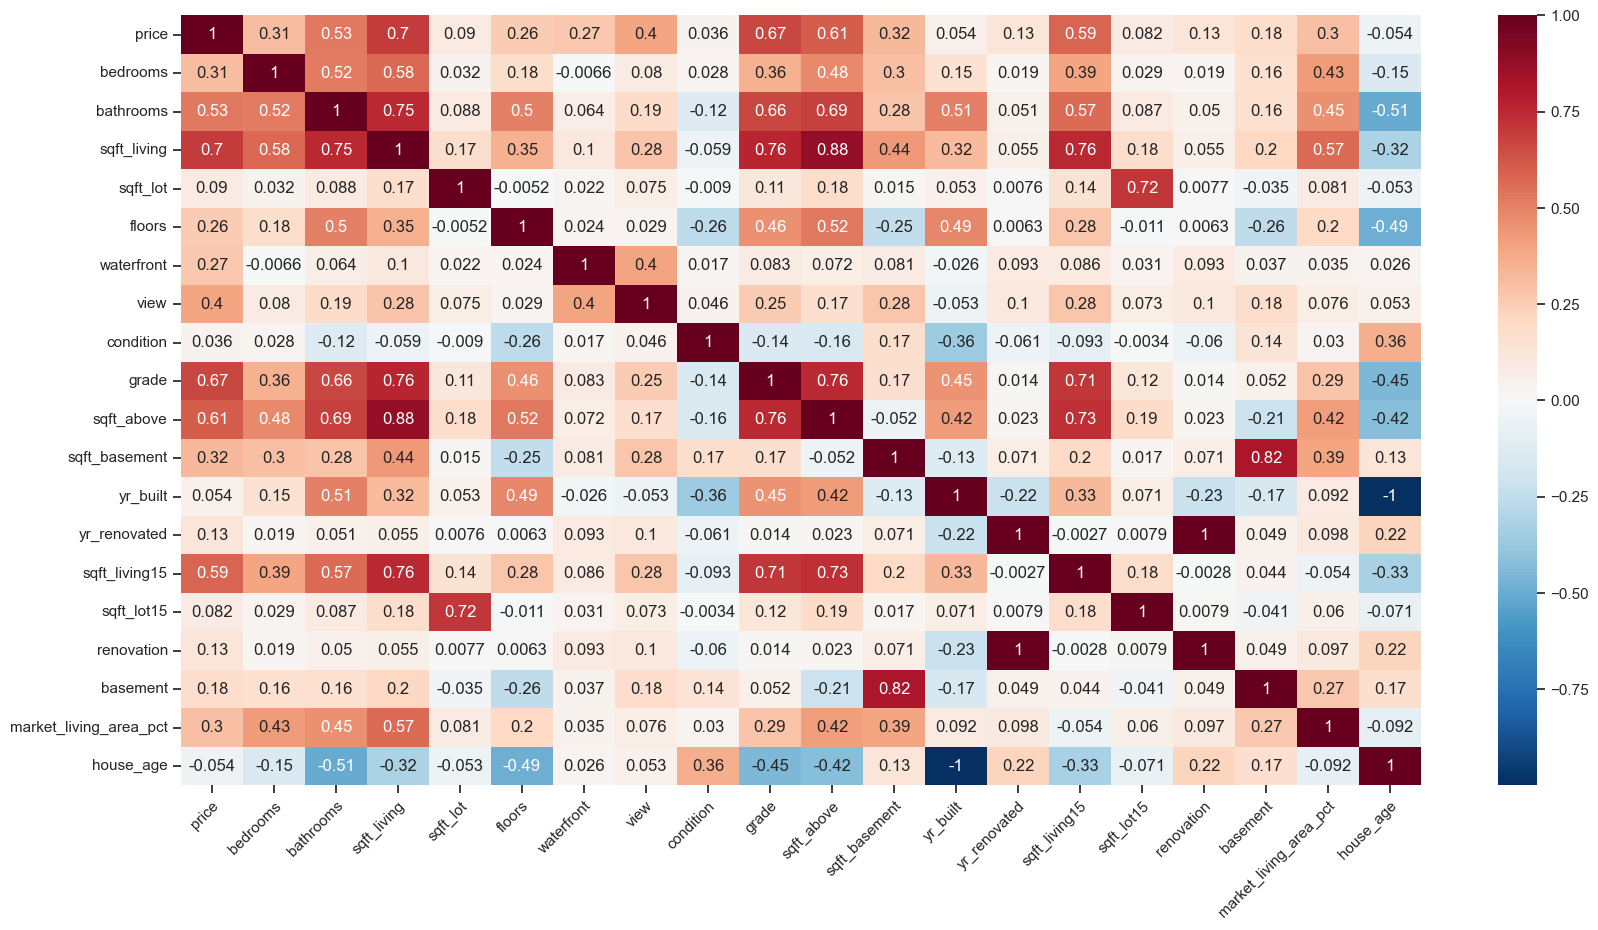

In [13]:
# Heatmap to plot out correlation between price and other relevant independent variables after feature engineering
plt.figure(figsize=(8, 5))
num_df = housing_df.select_dtypes(include=["float64", "int64"]).drop(
    columns=["id", "zipcode", "lat", "long"]
)

corr_v2 = num_df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_v2, annot=True, cmap="RdBu_r")
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

Removing `sqft_living`, `sqft_above`, `yr_built`, and `yr_renovated` addresses multi-collinearity in our new dataset.

In [14]:
# Define df for calculating vif
vif_df = num_df.drop(columns=["price"])

# Calculate VIF of all variables
logger.debug("Calculating VIF for all variables...")
print(calculate_vif(vif_df, cols_to_drop=None), "\n")

# Drop sqft_living and calculate VIF
sleep(0.5)
logger.debug("Dropping sqft_living and calculating VIF...")
print(calculate_vif(vif_df, cols_to_drop=["sqft_living"]), "\n")

# Drop sqft_living, yr_built and calculate VIF
sleep(0.5)
logger.debug("Dropping sqft_living, yr_built and calculating VIF...")
print(calculate_vif(vif_df, cols_to_drop=["sqft_living", "yr_built"]), "\n")

# Drop sqft_living, yr_built, sqft_above and calculate VIF
sleep(0.5)
logger.debug("Dropping sqft_living, yr_built, sqft_above and calculating VIF...")
print(
    calculate_vif(vif_df, cols_to_drop=["sqft_living", "yr_built", "sqft_above"]), "\n"
)

# Drop sqft_living, yr_built, sqft_above, yr_renovated and calculate VIF
sleep(0.5)
logger.debug("Dropping sqft_living, yr_built, sqft_above, yr_renovated and calculating VIF...")
print(
    calculate_vif(
        vif_df, cols_to_drop=["sqft_living", "yr_built", "sqft_above", "yr_renovated"]
    )
)

2024-12-01 16:28:53.713 | DEBUG    | __main__:<module>:5 - Calculating VIF for all variables...
2024-12-01 16:28:54.608 | WARNING  | __main__:calculate_vif:24 - Multi-collinearity detected!


                  Features           VIF
0                    const  1.866437e+07
1                 bedrooms  1.688324e+00
2                bathrooms  3.412204e+00
3              sqft_living           inf
4                 sqft_lot  2.089146e+00
5                   floors  1.935706e+00
6               waterfront  1.206706e+00
7                     view  1.406826e+00
8                condition  1.236127e+00
9                    grade  3.284004e+00
10              sqft_above           inf
11           sqft_basement           inf
12                yr_built  3.967841e+03
13            yr_renovated  1.612170e+04
14           sqft_living15  1.357379e+01
15              sqft_lot15  2.123069e+00
16              renovation  1.612061e+04
17                basement  3.514712e+00
18  market_living_area_pct  8.448037e+00
19               house_age  3.967137e+03 



2024-12-01 16:28:55.624 | DEBUG    | __main__:<module>:10 - Dropping sqft_living and calculating VIF...
2024-12-01 16:28:56.492 | WARNING  | __main__:calculate_vif:24 - Multi-collinearity detected!


                  Features           VIF
0                    const  1.866437e+07
1                 bedrooms  1.688324e+00
2                bathrooms  3.412204e+00
3                 sqft_lot  2.089146e+00
4                   floors  1.935706e+00
5               waterfront  1.206706e+00
6                     view  1.406826e+00
7                condition  1.236127e+00
8                    grade  3.284004e+00
9               sqft_above  1.786602e+01
10           sqft_basement  6.986979e+00
11                yr_built  3.967841e+03
12            yr_renovated  1.612170e+04
13           sqft_living15  1.357379e+01
14              sqft_lot15  2.123069e+00
15              renovation  1.612061e+04
16                basement  3.514712e+00
17  market_living_area_pct  8.448037e+00
18               house_age  3.967137e+03 



2024-12-01 16:28:57.507 | DEBUG    | __main__:<module>:15 - Dropping sqft_living, yr_built and calculating VIF...
2024-12-01 16:28:58.322 | WARNING  | __main__:calculate_vif:24 - Multi-collinearity detected!


                  Features           VIF
0                    const    211.283120
1                 bedrooms      1.688151
2                bathrooms      3.412151
3                 sqft_lot      2.089009
4                   floors      1.935179
5               waterfront      1.206692
6                     view      1.406488
7                condition      1.231902
8                    grade      3.283651
9               sqft_above     17.865433
10           sqft_basement      6.986102
11            yr_renovated  16121.476497
12           sqft_living15     13.573695
13              sqft_lot15      2.123053
14              renovation  16120.420457
15                basement      3.514699
16  market_living_area_pct      8.447893
17               house_age      2.027766 



2024-12-01 16:28:59.335 | DEBUG    | __main__:<module>:20 - Dropping sqft_living, yr_built, sqft_above and calculating VIF...
2024-12-01 16:29:00.117 | WARNING  | __main__:calculate_vif:24 - Multi-collinearity detected!


                  Features           VIF
0                    const    113.813008
1                 bedrooms      1.687160
2                bathrooms      3.331979
3                 sqft_lot      2.083304
4                   floors      1.930523
5               waterfront      1.204477
6                     view      1.406467
7                condition      1.228879
8                    grade      3.164502
9            sqft_basement      4.425358
10            yr_renovated  16121.124535
11           sqft_living15      3.678225
12              sqft_lot15      2.123017
13              renovation  16120.126707
14                basement      3.329916
15  market_living_area_pct      2.435796
16               house_age      2.014688 



2024-12-01 16:29:01.136 | DEBUG    | __main__:<module>:27 - Dropping sqft_living, yr_built, sqft_above, yr_renovated and calculating VIF...
2024-12-01 16:29:01.852 | SUCCESS  | __main__:calculate_vif:26 - No multi-collinearity, VIF all under 5


                  Features         VIF
0                    const  113.812480
1                 bedrooms    1.686781
2                bathrooms    3.326327
3                 sqft_lot    2.082987
4                   floors    1.929432
5               waterfront    1.201974
6                     view    1.406259
7                condition    1.224291
8                    grade    3.156125
9            sqft_basement    4.418728
10           sqft_living15    3.666553
11              sqft_lot15    2.122936
12              renovation    1.145707
13                basement    3.328935
14  market_living_area_pct    2.433287
15               house_age    2.014629


To supplement our analysis, [zipcode data for King County](https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-shorelines-zipcode-shore-area/about) was added to the dataset to capture potential spatial patterns in housing prices, such as proximity to commercial business districts. Using the county and city information from the shapefile, we plotted the distribution of housing prices by city to identify which city is the most expensive to live in based on housing prices.

In [14]:
# Load King County shapefile
kc_map = gpd.read_file(
    "data/Zipcodes_for_King_County_and_Surrounding_Area_(Shorelines)___zipcode_shore_area.shp"
)

# Convert coordinate reference system (CRS) for plotting
kc_map = kc_map.to_crs(epsg=4326)

# Extract zipcodes and their respective cities
zipcode_mapper = kc_map[["ZIPCODE", "PREFERRED_"]]
zipcode_mapper.rename(
    columns={"ZIPCODE": "zipcode", "PREFERRED_": "city"},
    inplace=True,
)

# Enhance housing sales dataset with county and city information
housing_df["zipcode"] = housing_df["zipcode"].astype(str)
housing_with_city_df = housing_df.merge(zipcode_mapper, how="left", on="zipcode")

# Get price distribution of houses for each city
housing_with_city_df.groupby("city")["price"].describe().map(lambda x: f"{x:,.0f}")

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
AUBURN,"1,263","303,554","114,314","90,000","230,000","280,000","345,000","930,000"
BELLEVUE,"1,407","898,188","559,443","247,500","550,000","749,000","999,974","7,062,500"
BLACK DIAMOND,100,"423,666","195,415","135,000","256,750","360,000","592,500","935,000"
BOTHELL,390,"490,351","121,690","245,500","412,100","470,000","550,000","1,075,000"
CARNATION,124,"455,617","258,603","80,000","308,500","415,000","536,000","1,680,000"
DUVALL,380,"424,789","130,346","119,500","330,000","401,250","500,000","1,015,000"
ENUMCLAW,468,"315,709","122,953","75,000","235,000","279,500","350,000","858,000"
FALL CITY,81,"580,527","377,405","142,000","340,000","460,000","700,000","1,862,000"
FEDERAL WAY,779,"289,385","108,340","86,500","225,450","268,000","320,000","1,275,000"


We further visualised the map of King County to illustrate the spatial distribution of housing prices. Notably, the most expensive homes are concentrated in areas such as Medina and Mercer Island. This is unsurprising as these regions are known for being home to some of the world’s wealthiest individuals, including tech leaders like Jeff Bezos and Bill Gates.

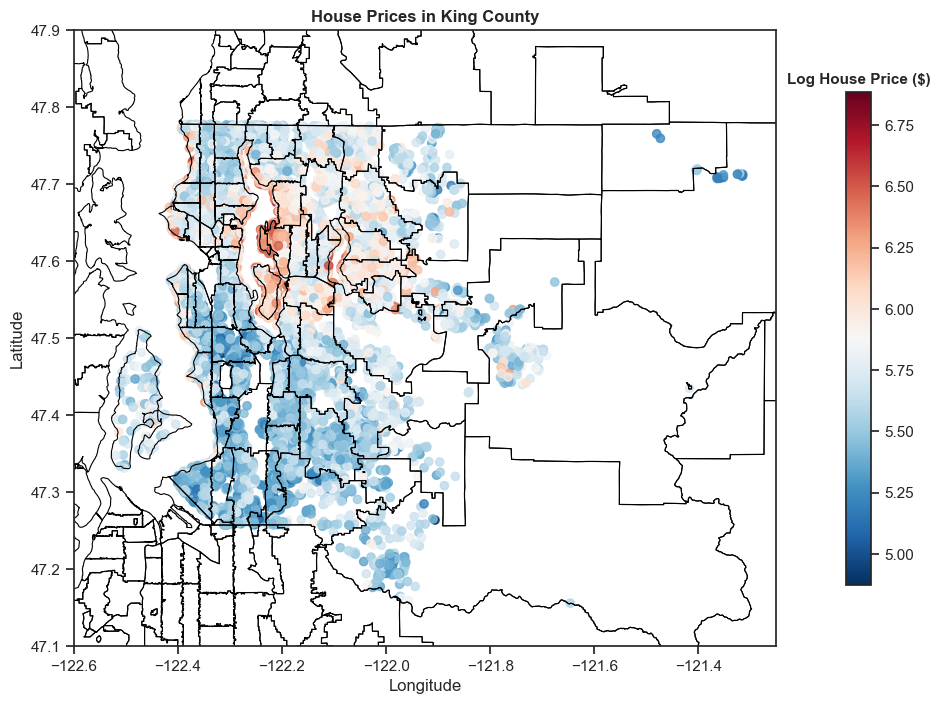

In [15]:
# Get latitude and longitude data for plotting
geom = [Point(xy) for xy in zip(housing_df["long"], housing_df["lat"])]
kc_house_geom_df = gpd.GeoDataFrame(
    housing_df, crs={"init": "epsg:4326"}, geometry=geom
)
kc_house_geom_df["log_price"] = np.log10(kc_house_geom_df["price"])

# Plot
fig, ax = plt.subplots(figsize=(18, 8))

kc_map.boundary.plot(edgecolor="black", ax=ax, linewidth=0.8)
kc_house_geom_df.plot(ax=ax, alpha=0.8, column="log_price", cmap="RdBu_r")
ax.set_xlim([-122.6, -121.25])
ax.set_ylim([47.1, 47.9])
ax.set_title("House Prices in King County", fontweight="bold")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Colour bar for to display resale price gradient, map colourmap and normalise range of values (min-max resale price) for colour mapping
cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(
    vmin=np.min(np.log10(housing_df["price"])),
    vmax=np.max(np.log10(housing_df["price"])),
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    location="right",
    shrink=0.8,
    pad=0.05,
)

# Format colour bar
# cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"${x:,.0f}"))
cbar.ax.set_title(
    "Log House Price ($)", fontsize=11, fontweight="bold", horizontalalignment="center"
)

plt.show()

# 4. Modelling <a id = '4'></a> 

Based on the analysis, the following variables were selected for modeling:  
`bedrooms`, `bathrooms`, `sqft_lot`, `floors`, `waterfront`, `view`, `condition`, `grade`, `sqft_basement`, `sqft_living15`, `sqft_lot15`, `renovation`, `basement`, `market_living_area_pct`, `house_age`, and `city`.

We log-transformed the housing prices to ensure that the variables are properly scaled. This transformation helps normalise the distribution of prices, reducing the impact of extreme outliers and making the model more robust and interpretable.

To faciliate model training and selection, the dataset was split into a train (80%) and test set (20%).

In [16]:
# Split data into training and testing set (80-20)
X = housing_with_city_df.drop(
    columns=[
        "id",
        "date",
        "price",
        "lat",
        "long",
        "zipcode",
        "sqft_above",  # removed because of multi-collinearity
        "sqft_living",  # removed because of multi-collinearity
        "yr_built",  # removed because of multi-collinearity
        "yr_renovated",  # removed because of multi-collinearity
    ]
)
y = np.log10(housing_with_city_df["price"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=10
)

X_train.head()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,sqft_living15,sqft_lot15,renovation,basement,market_living_area_pct,house_age,city
22395,3,2.50,5320,2.0,0,0,3,8,0,1820,5736,0,0,1.379121,9,SEATTLE
19956,3,1.50,15053,1.0,0,0,3,7,0,1250,13368,0,0,1.056000,35,WOODINVILLE
22397,2,2.25,835,2.0,0,0,3,7,200,1280,1246,0,1,1.000000,5,SEATTLE
15293,4,1.75,7200,1.0,0,0,3,6,700,1420,7200,0,1,1.098592,72,SEATTLE
14723,5,2.25,11965,2.0,0,0,4,8,0,2370,10715,0,0,1.215190,24,KENT


__Create pre-processing pipeline__  
Here, we developed a consistent and reusable pre-processing pipeline for transforming both training and test datasets.

The following transformers were created for our pre-processing pipeline:
- __Standard Scaler__: Scales numerical variables using mean and standard deviation from the training dataset.
- __One-Hot Encoder__: Encodes selected categorical variables.

In [17]:
# Define preprocessors
scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False)

cols_to_scale = [
    # "bedrooms",
    # "bathrooms",
    "sqft_lot",
    # "floors",
    # "waterfront",
    # "view",
    # "condition",
    # "grade",
    "sqft_basement",
    "sqft_living15",
    "sqft_lot15",
    # "renovation",
    # "basement",
    # "market_living_area_pct",
    "house_age",
]
cols_to_encode = ["city"]

pre_processing_pipeline = ColumnTransformer(
    transformers=[
        ("scale", scaler, cols_to_scale),
        ("encode", ohe, cols_to_encode),
    ],
    remainder="passthrough",  # Leave other columns untouched
)

# Fit-transform X_train data
pre_processing_pipeline.fit(X_train)
X_train_cleaned = pre_processing_pipeline.transform(X_train)

# print(f"Feature names: {pre_processing_pipeline.get_feature_names_out()}")

# Transform X_test data
X_test_cleaned = pre_processing_pipeline.transform(X_test)

The following regressors with default hyperparameter settings were evaluated:
1. Dummy Regressor (to develop a modelling baseline);
2. Linear Regression;
3. Ridge Regression;
4. XGBoost Regressor; and
5. Random Forest Regressor.

The pre-processing and modeling pipelines were then chained to:
- Pre-process the input data;
- Fit the relevant models;
- Perform 10-fold cross-validation; and
- Evaluate cross-validation scores for a first-cut assessment of model performance.

Here, root mean square error (RMSE) and R-squared (R²) were used to evaluate the performance of our linear regression models. Specifically, RMSE measures the error rate of model predictions in the same units as the response variable (log price) while R-squared represents the proportion of variance in the response variable that is explained by the model.

In [18]:
# Instantiate candidate regression models using default hyperparameters
dummy_reg = DummyRegressor(strategy="mean")
linear_reg = LinearRegression()
ridge_reg = Ridge()
xgb_reg = XGBRegressor(random_state=10)
rf_reg = RandomForestRegressor(n_jobs=-1, random_state=10)

models = [dummy_reg, linear_reg, ridge_reg, xgb_reg, rf_reg]

# Model selection
logger.info("Performing model selection based on CV accuracy")
for i in range(len(models)):
    # Establish pipeline
    complete_pipeline = make_pipeline(pre_processing_pipeline, models[i])
    kf = KFold(n_splits=10, shuffle=True, random_state=10)

    # Calculate cv score
    logger.debug(f"Fitting model: {models[i].__class__.__name__}")
    print(
        f"CV RMSE score: {cross_val_score(complete_pipeline, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean():.5f}"
    )
    print(
        f"CV R-squared score: {cross_val_score(complete_pipeline, X_train, y_train, cv=kf, scoring='r2').mean():.5f}"
    )
    sleep(1)

logger.success("Models successfully fitted!")

2024-11-30 19:01:01.799 | INFO     | __main__:<module>:11 - Performing model selection based on CV accuracy
2024-11-30 19:01:01.800 | DEBUG    | __main__:<module>:18 - Fitting model: DummyRegressor


CV RMSE score: -0.22662
CV R-squared score: -0.00132


2024-11-30 19:01:02.976 | DEBUG    | __main__:<module>:18 - Fitting model: LinearRegression


CV RMSE score: -0.10523
CV R-squared score: 0.78376


2024-11-30 19:01:09.559 | DEBUG    | __main__:<module>:18 - Fitting model: Ridge


CV RMSE score: -0.10516
CV R-squared score: 0.78407


2024-11-30 19:01:10.988 | DEBUG    | __main__:<module>:18 - Fitting model: XGBRegressor


CV RMSE score: -0.09205
CV R-squared score: 0.83450


2024-11-30 19:01:15.209 | DEBUG    | __main__:<module>:18 - Fitting model: RandomForestRegressor


CV RMSE score: -0.09489
CV R-squared score: 0.82404


2024-11-30 19:01:48.567 | SUCCESS  | __main__:<module>:27 - Models successfully fitted!


Since XGBoost Regressor yielded the best results with the lowest RMSE of 0.092 and the highest R-squared of 83.5%, we decided to proceed with the model for hyperparameter tuning using `GridSearchCV` to further optimise its performance.

In [19]:
# Instantiate candidate classification models
xgb_reg = XGBRegressor(random_state=10)

# Model hyperparameters for tuning
param_grid = {
    "xgbregressor__gamma": [0, 0.01, 0.05],
    "xgbregressor__reg_alpha": [0.1, 0.2],
    "xgbregressor__reg_lambda": [0.1, 0.2],
    "xgbregressor__max_depth": [1, 3, 5],
    "xgbregressor__min_child_weight": [1, 3, 5],
    "xgbregressor__learning_rate": [0.05, 0.1],
    "xgbregressor__n_estimators": [20, 30, 50],
    "xgbregressor__subsample": [0.4, 0.5, 0.6],
    "xgbregressor__colsample_bytree": [0.9, 1],
}

# Iterate through list of models to fit data, tune hyperparameters, and test against validation set for model selection
logger.info("Performing hyperparameter tuning using GridSearchCV")

# Establish pipeline
complete_pipeline = make_pipeline(pre_processing_pipeline, xgb_reg)

# Hyperparameter tuning using grid search
kf = KFold(n_splits=5, shuffle=True, random_state=10)
grid = GridSearchCV(
    complete_pipeline,
    param_grid=param_grid,
    cv=kf,
)
grid.fit(X_train, y_train)

# Retrieve best set of hyperparameters for each model
logger.debug(f"Fitting model: {xgb_reg.__class__.__name__}")

print(f"Best parameters: {grid.best_params_}")
print(
    f"CV RMSE score: {cross_val_score(complete_pipeline, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean():.5f}"
)
print(
    f"CV R-squared score: {cross_val_score(complete_pipeline, X_train, y_train, cv=kf, scoring='r2').mean():.5f}"
)
sleep(1)
logger.success("Models successfully fitted!")

2024-11-30 19:01:48.584 | INFO     | __main__:<module>:18 - Performing hyperparameter tuning using GridSearchCV
2024-11-30 19:17:38.617 | DEBUG    | __main__:<module>:33 - Fitting model: XGBRegressor


Best parameters: {'xgbregressor__colsample_bytree': 1, 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__min_child_weight': 5, 'xgbregressor__n_estimators': 50, 'xgbregressor__reg_alpha': 0.1, 'xgbregressor__reg_lambda': 0.2, 'xgbregressor__subsample': 0.5}
CV RMSE score: -0.09271
CV R-squared score: 0.83237


2024-11-30 19:17:41.473 | SUCCESS  | __main__:<module>:43 - Models successfully fitted!


In [20]:
# Predict on test set
y_pred = grid.predict(X_test)

logger.info(f"Evaluation of {xgb_reg.__class__.__name__} model")
print(f"Test RMSE score: {root_mean_squared_error(y_test, y_pred):.5f}")
print(f"Test R-squared score: {r2_score(y_test, y_pred):.5f}")

2024-11-30 19:17:41.508 | INFO     | __main__:<module>:4 - Evaluation of XGBRegressor model


Test RMSE score: 0.09730
Test R-squared score: 0.81535


# 5. Conclusion <a id = '5'></a> 

The final model yielded an RMSE of 0.097 and an R-squared of 81.5%, significantly outperforming the baseline dummy regressor.

Overall, this project demonstrates the use of linear regerssion models to predict housing prices based on available housing data. Areas for improvement to boost prediction accuracy include:
1.	__Feature Engineering__: Develop more features using available data to better elucidate underlying patterns/trends.
2.	__Robust Feature Selection__: Beyond VIF-based feature selection, utilise methods like Recursive Feature Elimination (RFE) or feature importance from Random Forest Regressors to refine feature sets.
3.	__Exploring Additional Models__: Experiment with other models such as decision tree regressors or ensemble approaches like stacked regressors which may potentially improve performance.